In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Suppress ta warnings
import warnings
warnings.filterwarnings("ignore")

# Auto reload local files
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if 'src' not in sys.path:
    sys.path.insert(0, '../src')

In [2]:
# Read SPY csv, define config
spy_constituents = list(pd.read_csv('../../data/spy_constituents.csv', header=0)['Symbol'])
random.shuffle(spy_constituents)

tickers = spy_constituents[:50]
start_date = "2000-01-01"
end_date = "2025-01-01"
predict_window = 14

In [3]:
# Load the data from db
from sklearn.model_selection import train_test_split

import datastore as ds
from technical_signals import TechnicalSignalSet

#ds.download_daily_candlesticks(tickers, start_date, end_date)
candlesticks = ds.get_daily_candlesticks(tickers, start_date, end_date)

Xs = []
ys = []

for ticker in tickers:
    try:
        technical_sigs = TechnicalSignalSet(candlesticks[ticker], predict_window)
        X, y, Xy_date = technical_sigs.to_xy()
        Xs.append(X)
        ys.append(y)
    except Exception as ex:
        print(f"Exception on {ticker}:")
        print(ex)

X = np.concatenate(Xs, axis=0)
y = np.concatenate(ys, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gc


def round_batch_size(sample_count, approximately, leeway=None):
    """
    Round batch size to a more suitable value. This helps to avoid a
    problem where the final batch has a lot of samples, but not enough for
    a full batch, leading to many samples being thrown out.

    approximately: int, leeway: int
      decide on a chunk size around a number, with specified leeway
      (leeway defaults to `approximately // 10`).
    """
    if leeway is None:
        leeway = approximately // 10
    
    # Get the number of leftover samples if we use the suggested batch size
    best_leftover = sample_count - np.floor(sample_count / approximately) * approximately

    # Brute-force search for the value that yeilds the fewest leftovers
    # within the given leeway range.
    best_chunk_count = approximately
    for offset in range(-leeway, leeway):
        chunk_size = approximately + offset
        leftover = sample_count - np.floor(sample_count / chunk_size) * chunk_size
        if leftover < best_leftover:
            best_leftover = leftover
            best_chunk_count = chunk_size
    return best_chunk_count
            

batch_size = round_batch_size(X_train.shape[0], 1024, leeway=200)
n_features = X_train.shape[1]

# Convert X, y to torch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train.reshape(y_train.shape[0], 1)).float()
y_test_tensor = torch.from_numpy(y_test.reshape(y_test.shape[0], 1)).float()

print(X_train_tensor.shape)
print('Batch size:', batch_size)

# Generators
training_set = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(training_set, shuffle=True, batch_size=batch_size)

validation_set = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_test = DataLoader(validation_set, shuffle=True, batch_size=batch_size)

# Release duplicated memory
try:
    del X
    del y
    del Xs
    del ys
    #del X_train
    #del X_test
    #del y_train
    #del y_test
    del X_train_tensor
    del X_test_tensor
    del y_train_tensor
    del y_test_tensor
except:
    pass
gc.collect()

torch.Size([210530, 58])
Batch size: 1138


9

In [5]:
n_outputs = 1

net = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, n_outputs),
)

net = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, n_outputs),
)

In [6]:
device = torch.device("cuda")

# Set device for model
net = net.to(device)

# Select optimizerand loss criteria
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 

# Training the model
for epoch in range(100):
    train_loss = 0.0
    
    # Training
    net.train()
    for local_batch, local_labels in dataloader_train:
        if local_batch.shape[0] != batch_size:
            print(f"Wrong train batch size. Skipping batch.\nThrowing away {local_batch.shape[0]} samples.")
            continue
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass: Compute predicted y by passing x to the model 
        y_pred = net(local_batch)
        # Compute and print loss 
        loss = criterion(y_pred, local_labels)
        # Zero gradients, perform a backward pass, update the weights. 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        # Update loss
        train_loss += loss.item()

    # Validation
    net.eval()
    valid_loss = 0.0
    for data, labels in dataloader_test:
        if data.shape[0] != batch_size:
            continue
        data, labels = data.to(device), labels.to(device)
        
        target = net(data)
        loss = criterion(target,labels)
        valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(dataloader_train)} \t\t Validation Loss: {valid_loss / len(dataloader_test)}')

Epoch 1 		 Training Loss: 0.9775732446361233 		 Validation Loss: 0.9116013844807943
Epoch 2 		 Training Loss: 0.9453988455437325 		 Validation Loss: 0.9070850383667719
Epoch 3 		 Training Loss: 0.9172704593555348 		 Validation Loss: 0.8637737688564119
Epoch 4 		 Training Loss: 0.892783223293923 		 Validation Loss: 0.8462776030812945
Epoch 5 		 Training Loss: 0.8655272081091597 		 Validation Loss: 0.84571411496117
Epoch 6 		 Training Loss: 0.8411213820045059 		 Validation Loss: 0.8128599921862284
Epoch 7 		 Training Loss: 0.8115977728689039 		 Validation Loss: 0.7843970088731675
Epoch 8 		 Training Loss: 0.7812252424858712 		 Validation Loss: 0.7782256291026161
Epoch 9 		 Training Loss: 0.7561511487574191 		 Validation Loss: 0.7460607488950094
Epoch 10 		 Training Loss: 0.7269466725555627 		 Validation Loss: 0.750560048080626
Epoch 11 		 Training Loss: 0.7012188247732214 		 Validation Loss: 0.7214590509732565
Epoch 12 		 Training Loss: 0.6798862834234496 		 Validation Loss: 0.6911357243

Epoch 98 		 Training Loss: 0.2781668265123625 		 Validation Loss: 0.40725867946942645
Epoch 99 		 Training Loss: 0.27683651366749323 		 Validation Loss: 0.4073655605316162
Epoch 100 		 Training Loss: 0.2781362549678699 		 Validation Loss: 0.40019121056511286


Ticker: MMC
182 buy/sells performed - 3.194103194103194% of the time
Stock price change: 104.5587161471132%
Total gain/loss: 16.119600067138673%
ROI: 18.239030061198388%
{'cash': 9774.520080566406, 'assets': 11, 'latest_price': 167.0399932861328, 'total_value': 11611.960006713867, 'roi': 0.18239030061198389}


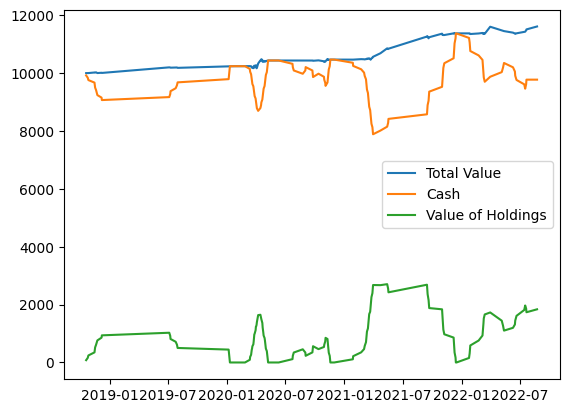

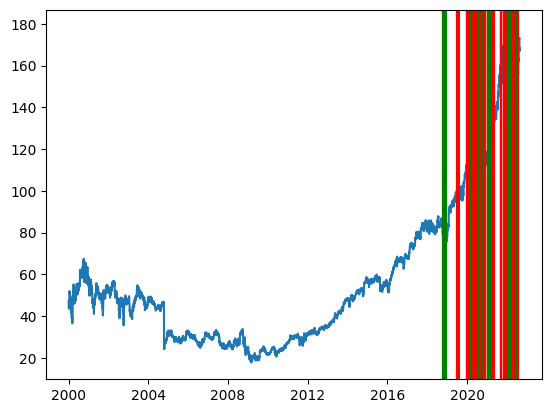

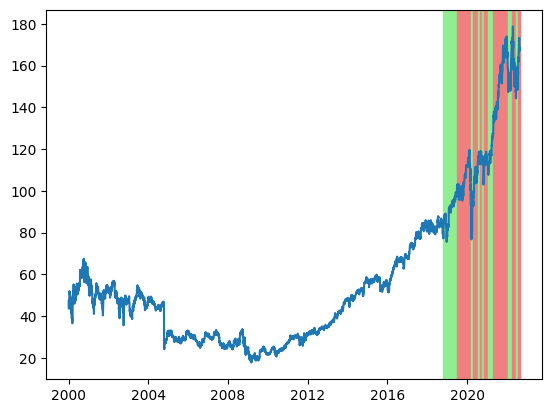

{'average_gainloss': 1611.9600067138672,
 'results': {'MMC': {'cash': 9774.520080566406,
   'assets': 11,
   'latest_price': 167.0399932861328,
   'total_value': 11611.960006713867,
   'roi': 0.18239030061198389}}}

In [8]:
import backtest as bt
from strategy import PretrainedModelStrategy, SignalModelStrategy
from technical_signals import TechnicalSignalSet
from sklearn.svm import SVR

random.shuffle(spy_constituents)

# XXX temporary - need to rework concurrency to be suitable for CUDA
# (Must use `spawn` as opposed to `fork` based concurrency I believe - separate OS processes?)
net = net.to(torch.device('cpu'))

def predict(net):
    return lambda X:\
        net(torch.from_numpy(X).float().cpu()).detach().numpy()

def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

strategy = PretrainedModelStrategy(predict(net), df_to_signal_set, cutoff=0.95, bias=0.2)
#strategy = SignalModelStrategy(SVR(), lambda df: TechnicalSignalSet(df, predict_window=14), cutoff=1., bias=0.1)
bt.comprehensive_backtest(strategy, spy_constituents[:1], "2000-01-01", "2025-01-01", plot=True, train_test_ratio=0.8)

In [25]:
from prediction import Prediction, predict_price_change
from predictive_model import PredictiveModel
from datetime import datetime

net = net.to(torch.device('cpu'))

def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

model = PredictiveModel(net, "TorchMATI", predict_window, datetime.now())

predictions = predict_price_change(model, df_to_signal_set, tickers[:10])
ds.save_predictions([p for t, p in predictions.items()])
ds.get_predictions(tickers[:10], "2020-01-01", "2025-01-01")

{'WM': [Prediction(model_id=TorchMATI|14|2022-08-24 18:00:06.624274, created_date=2022-08-24 00:00:00, predict_from_date=2022-08-24 00:00:00, window=14, ticker=WM, prediction=[-1.0776311159133911])],
 'DG': [Prediction(model_id=TorchMATI|14|2022-08-24 18:00:06.624274, created_date=2022-08-24 00:00:00, predict_from_date=2022-08-24 00:00:00, window=14, ticker=DG, prediction=[-4.932541370391846])],
 'ALK': [Prediction(model_id=TorchMATI|14|2022-08-24 18:00:06.624274, created_date=2022-08-24 00:00:00, predict_from_date=2022-08-24 00:00:00, window=14, ticker=ALK, prediction=[1.0942524671554565])],
 'MDT': [Prediction(model_id=TorchMATI|14|2022-08-24 18:00:06.624274, created_date=2022-08-24 00:00:00, predict_from_date=2022-08-24 00:00:00, window=14, ticker=MDT, prediction=[3.4727048873901367])],
 'V': [Prediction(model_id=TorchMATI|14|2022-08-24 18:00:06.624274, created_date=2022-08-24 00:00:00, predict_from_date=2022-08-24 00:00:00, window=14, ticker=V, prediction=[-1.3901102542877197])],
 

In [ ]:
torch.save(net.state_dict(), model.id)

In [ ]:
import torch
import torch.nn as nn

n_features = X_train.shape[1]
net = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, n_outputs),
)
net = net.load_state_dict(torch.load('TorchMATI-14-24-08-2022T'))